In [1]:
import tensorflow as tf
import numpy as np
import pickle

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/talipov/MyProjects/projectX/acosta_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from sklearn.cross_validation import  train_test_split

/Users/talipov/MyProjects/projectX/acosta_env/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.cross_validation import  train_test_split
# Набор данных MNIST – рукописные цифры
X, Y = [], []
with open('./../dz2/train.csv','r') as f:
    f.readline()
    for line in f:
        data = line.split(',')
        Y.append(int(data[0]))
        X.append([int(p) for p in data[1:]])
X = np.array(X)
Y = np.array(Y)
_X = np.reshape(X, newshape=(-1, 28,28, 1))
X_train, X_test, Y_train, Y_test = train_test_split(_X, Y, test_size=0.2)

In [6]:
X.shape

(42000, 784)

In [7]:
Y.shape

(42000,)

In [9]:
_X.shape

(42000, 28, 28, 1)

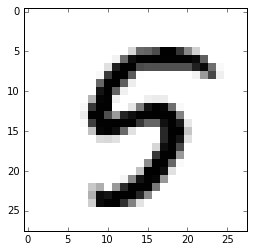

In [10]:
plt.figure()
plt.imshow(-_X[8].reshape((28,28)), interpolation='nearest', cmap='gray')
plt.show()

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(_X, Y, test_size=0.2)

In [12]:
x = tf.placeholder(
    shape = [None, 28, 28, 1],
    dtype=tf.float32
)
y = tf.placeholder(
    shape = [None, 10],
    dtype=tf.float32
)

In [13]:
x

<tf.Tensor 'Placeholder:0' shape=(?, 28, 28, 1) dtype=float32>

In [14]:
conv1 = tf.layers.conv2d(
      inputs=x,
      filters=16,
      kernel_size=[3, 3],
      strides=(1, 1),
      padding='valid',#"same",
      activation=tf.nn.relu
)

In [15]:
conv1

<tf.Tensor 'conv2d/Relu:0' shape=(?, 26, 26, 16) dtype=float32>

In [16]:
pool1 = tf.layers.max_pooling2d(
    inputs=conv1, 
    pool_size=[3, 3],
    strides=2,
    padding='same'
)

In [17]:
pool1

<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 13, 13, 16) dtype=float32>

In [18]:
conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu
)


In [19]:
conv2

<tf.Tensor 'conv2d_2/Relu:0' shape=(?, 13, 13, 32) dtype=float32>

In [20]:
pool2 = tf.layers.max_pooling2d(
    inputs=conv2,
    pool_size=[3, 3],
    strides=2,
    padding="same",
)

In [21]:
pool2

<tf.Tensor 'max_pooling2d_2/MaxPool:0' shape=(?, 7, 7, 32) dtype=float32>

In [22]:
conv3 = tf.layers.conv2d(
      inputs=pool2,
      filters=48,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu
)

In [23]:
conv3

<tf.Tensor 'conv2d_3/Relu:0' shape=(?, 7, 7, 48) dtype=float32>

In [24]:
pool3 = tf.layers.max_pooling2d(
    inputs=conv3,
    pool_size=[3, 3],
    strides=2,
    padding="same",
)

In [25]:
pool3

<tf.Tensor 'max_pooling2d_3/MaxPool:0' shape=(?, 4, 4, 48) dtype=float32>

In [26]:
conv4 = tf.layers.conv2d(
      inputs=pool3,
      filters=64,
      kernel_size=[3, 3],
      padding="valid",
      activation=tf.nn.relu
)

In [27]:
conv4

<tf.Tensor 'conv2d_4/Relu:0' shape=(?, 2, 2, 64) dtype=float32>

In [28]:
conv_out = tf.reshape(conv4, [-1, 4*64])

In [29]:
conv_out

<tf.Tensor 'Reshape:0' shape=(?, 256) dtype=float32>

In [30]:
dense = tf.layers.dense(inputs=conv_out, units=64, activation=tf.nn.relu)

In [31]:
dense

<tf.Tensor 'dense/Relu:0' shape=(?, 64) dtype=float32>

In [32]:
logits = tf.layers.dense(inputs=dense, units=10)

In [33]:
logits

<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>

In [34]:
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
)

In [35]:
loss

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [36]:
train_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

In [37]:
softmax = tf.nn.softmax(logits)

In [38]:
softmax

<tf.Tensor 'Softmax:0' shape=(?, 10) dtype=float32>

In [39]:
def iter_data(batch_size, X, Y):
    batch_x, batch_y = [], []
    for x,y in zip(X,Y):
        labels = np.zeros(shape=(10,))
        labels[y]=1
        batch_x.append(x)
        batch_y.append(labels)
        if len(batch_x)< batch_size:
            yield np.array(batch_x), np.array(batch_y)
            batch_x, batch_y = [], []
    if batch_x:
        yield np.array(batch_x), np.array(batch_y)

In [40]:
with tf.Session() as sess:
    sess.run(
        tf.global_variables_initializer()
    )
    saver = tf.train.Saver()
    for epoch in range(3):
        train_loss = []
        for batch_x, batch_y in iter_data(batch_size=128, X=X_train, Y=Y_train):
            _, _loss = sess.run(
                [train_op, loss],
                feed_dict={
                    x: batch_x,
                    y: batch_y
                }
            )
            train_loss.append(_loss)
        print('train', np.array(train_loss).mean())
        
        test_loss = []
        for batch_x, batch_y in iter_data(batch_size=128, X=X_test, Y=Y_test):
            _loss = sess.run(
                [loss],
                feed_dict={
                    x: batch_x,
                    y: batch_y
                }
            )
            test_loss.append(_loss)
        print('test', np.array(test_loss).mean())
    saver.save(sess, save_path='./mnist_.model')

# train 0.35866508
# test 0.1540757
# train 0.11430497
# test 0.093042366
# train 0.08004785
# test 0.08219576

train 0.31635156
test 0.110790685
train 0.09431022
test 0.08678603
train 0.06410209
test 0.0692638


In [42]:
def visualize(obj):
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, './mnist_.model')
        c1, p1, c2, p2, c3, p3, c4,_dense, _softmax = sess.run(
            [
                conv1,
                pool1,
                conv2,
                pool2,
                conv3,
                pool3,
                conv4,
                dense,
                softmax,
            ],
            feed_dict={x: [obj]}
        )
        
    shape = c1.shape
    img = np.reshape(c1, newshape=(shape[1],shape[2],shape[3])).transpose(0,2,1).reshape(shape[1],shape[2]*shape[3])
    plt.figure(figsize=(20,10))
    plt.imshow(-img,interpolation='nearest', cmap='gray')
    plt.show()
    
    shape = p1.shape
    img = np.reshape(p1, newshape=(shape[1],shape[2],shape[3])).transpose(0,2,1).reshape(shape[1],shape[2]*shape[3])
    plt.figure(figsize=(20,10))
    plt.imshow(-img,interpolation='nearest', cmap='gray')
    plt.show()
    
    shape = c2.shape
    img = np.reshape(c2, newshape=(shape[1],shape[2],shape[3])).transpose(0,2,1).reshape(shape[1],shape[2]*shape[3])
    plt.figure(figsize=(30,10))
    plt.imshow(-img,interpolation='nearest', cmap='gray')
    plt.show()
    
    shape = p2.shape
    img = np.reshape(p2, newshape=(shape[1],shape[2],shape[3])).transpose(0,2,1).reshape(shape[1],shape[2]*shape[3])
    plt.figure(figsize=(30,10))
    plt.imshow(-img,interpolation='nearest', cmap='gray')
    plt.show()
    
    shape = c3.shape
    img = np.reshape(c3, newshape=(shape[1],shape[2],shape[3])).transpose(0,2,1).reshape(shape[1],shape[2]*shape[3])
    plt.figure(figsize=(30,10))
    plt.imshow(-img,interpolation='nearest', cmap='gray')
    plt.show()
    
    shape = p3.shape
    img = np.reshape(p3, newshape=(shape[1],shape[2],shape[3])).transpose(0,2,1).reshape(shape[1],shape[2]*shape[3])
    plt.figure(figsize=(30,10))
    plt.imshow(-img,interpolation='nearest', cmap='gray')
    plt.show()
    
    shape = c4.shape
    img = np.reshape(c4, newshape=(shape[1],shape[2],shape[3])).transpose(0,2,1).reshape(shape[1],shape[2]*shape[3])
    plt.figure(figsize=(30,10))
    plt.imshow(-img,interpolation='nearest', cmap='gray')
    plt.show()
    
    plt.figure(figsize=(20,10))
    plt.imshow(-_dense,interpolation='nearest', cmap='gray')
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.imshow(-_softmax,interpolation='nearest', cmap='gray')
    plt.show()

INFO:tensorflow:Restoring parameters from ./mnist_.model


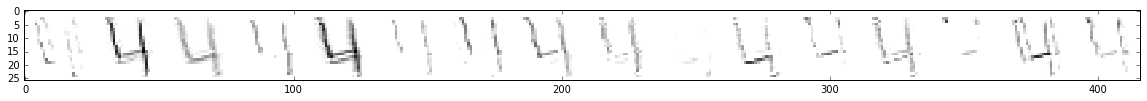

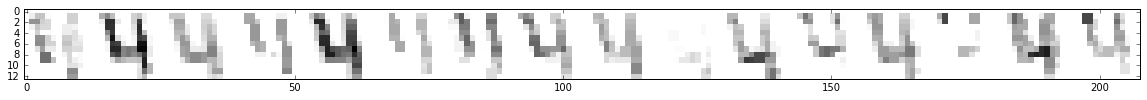

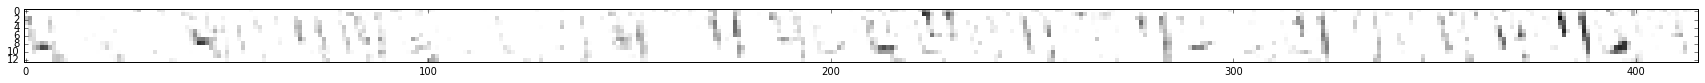

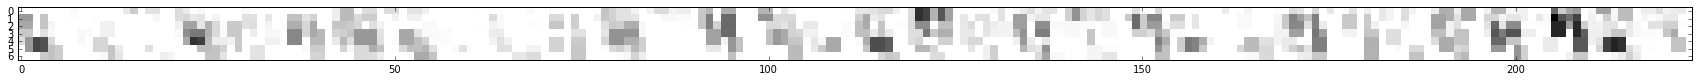

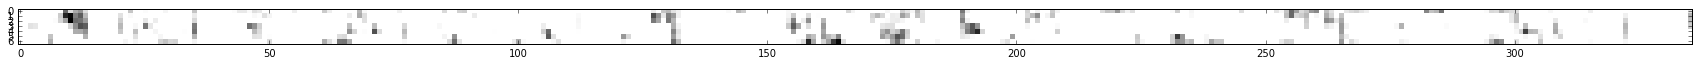

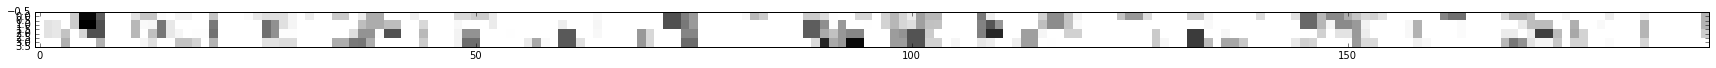

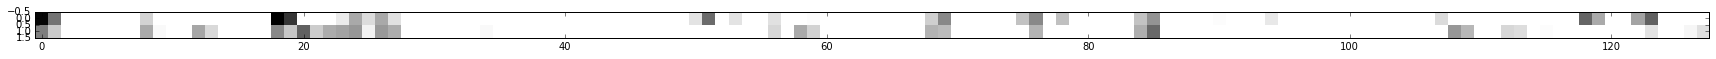

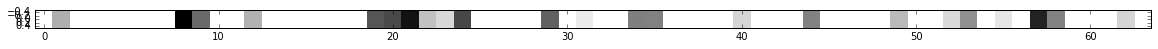

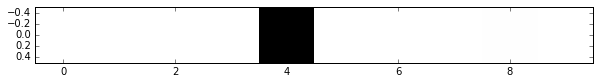

In [43]:
visualize(_X[3])

INFO:tensorflow:Restoring parameters from ./mnist_.model


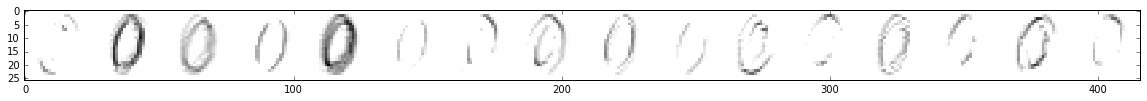

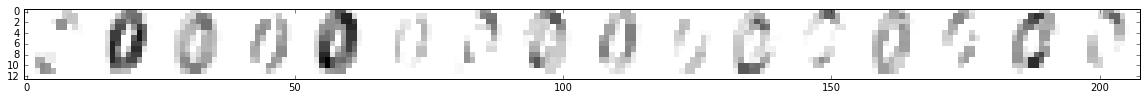

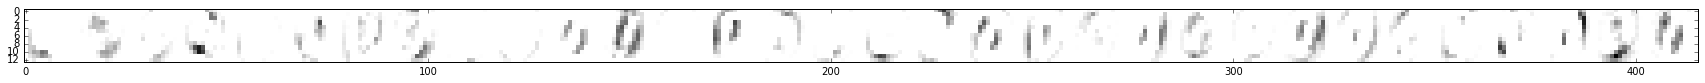

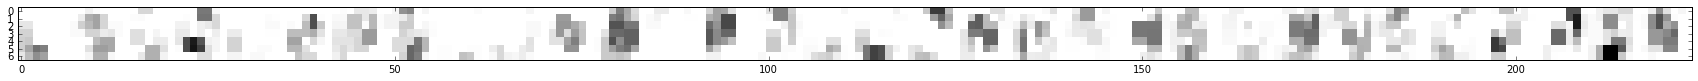

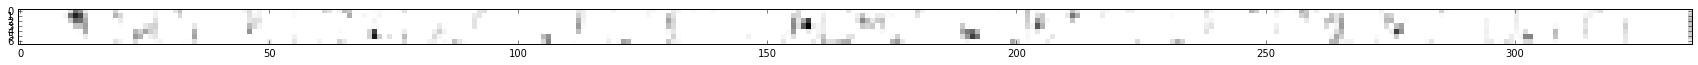

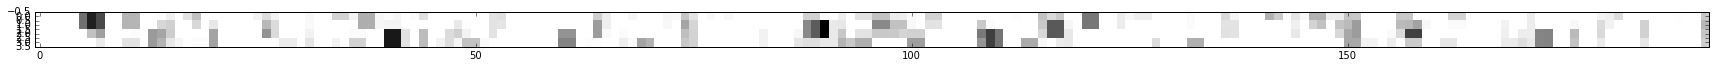

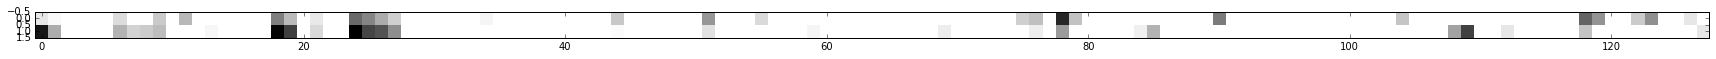

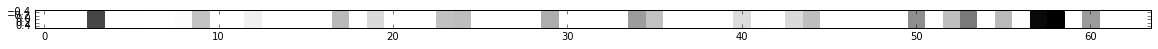

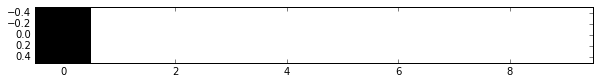

In [44]:
visualize(_X[5])

INFO:tensorflow:Restoring parameters from ./mnist_.model


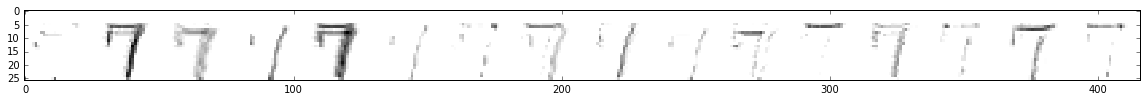

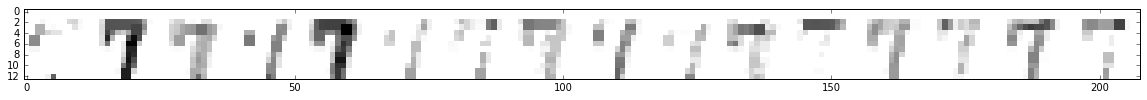

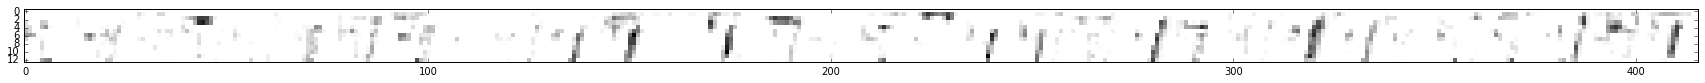

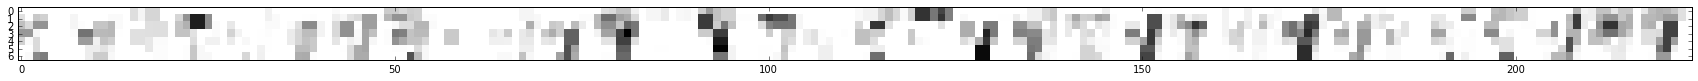

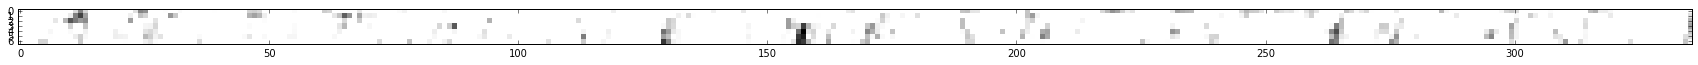

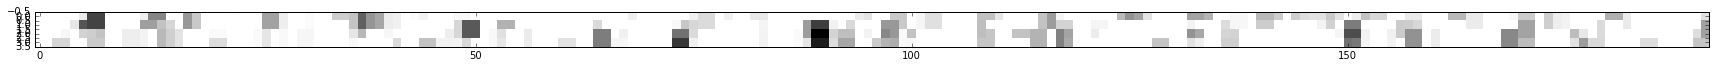

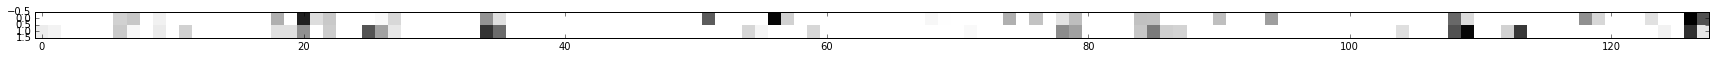

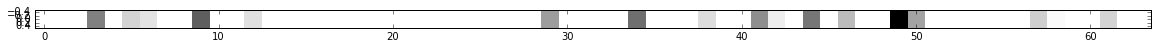

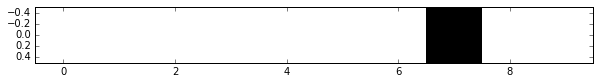

In [45]:
visualize(_X[6])

INFO:tensorflow:Restoring parameters from ./mnist_.model


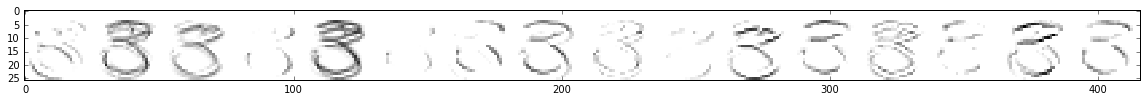

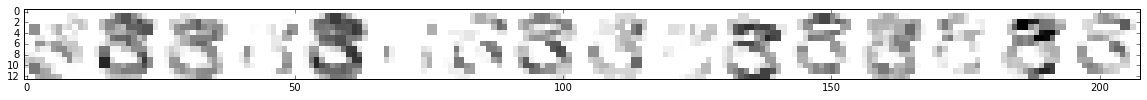

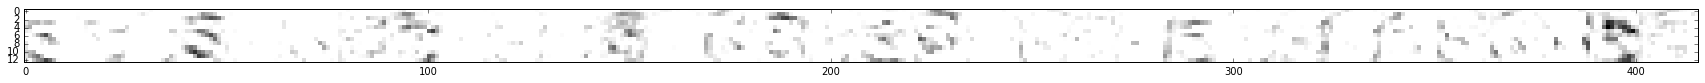

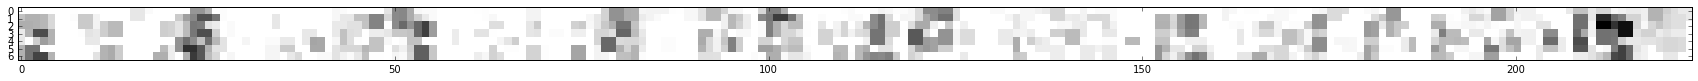

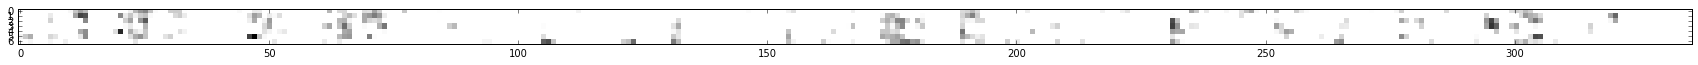

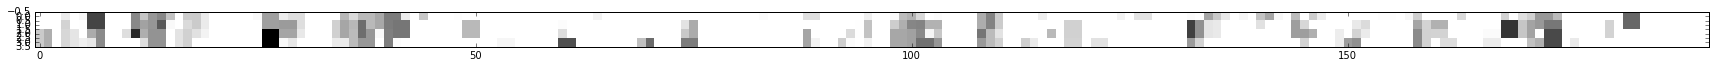

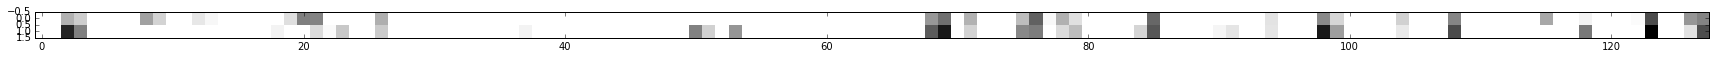

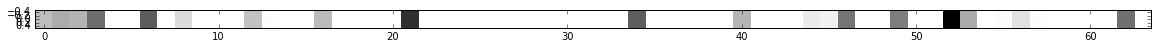

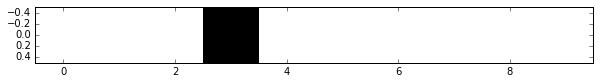

In [46]:
visualize(_X[7])

INFO:tensorflow:Restoring parameters from ./mnist_.model


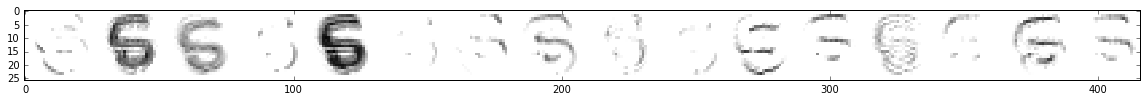

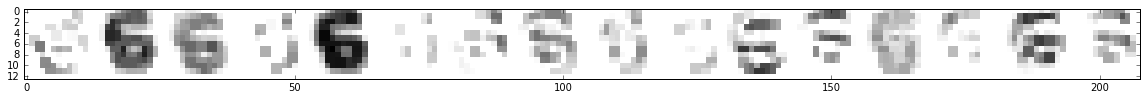

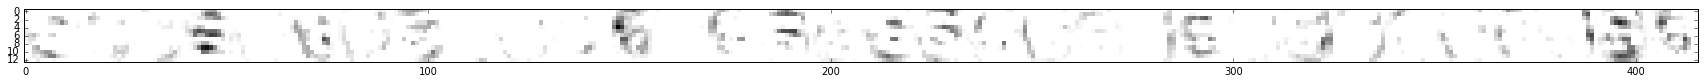

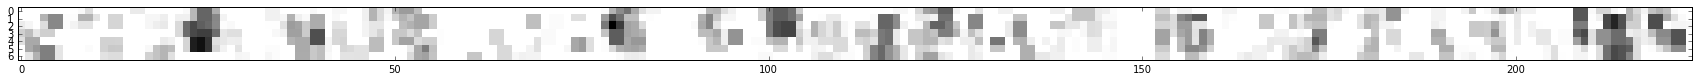

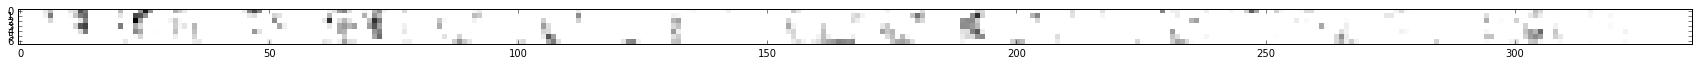

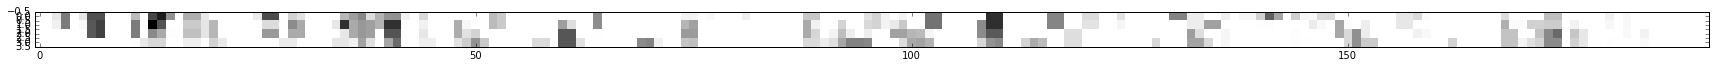

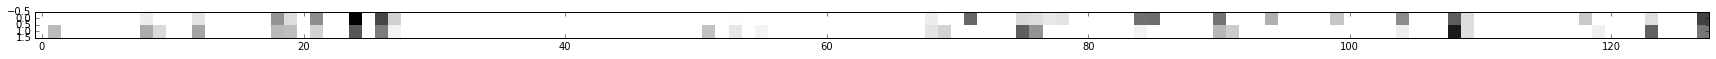

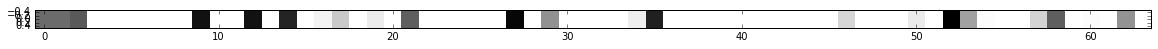

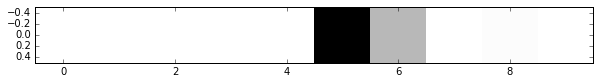

In [47]:
visualize(_X[19])